In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np


In [56]:

# Step 1: Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Step 2: Preprocess the data
# Reshape the images to 28x28x1 (grayscale) and normalize to [0, 1]
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [57]:

# Step 3: Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for MNIST digits (0-9)
])

# Step 4: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))

# Step 6: Save the trained model
model.save('mnist_model.h5')


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8666 - loss: 0.4431 - val_accuracy: 0.9800 - val_loss: 0.0647
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9819 - loss: 0.0550 - val_accuracy: 0.9866 - val_loss: 0.0412
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9885 - loss: 0.0376 - val_accuracy: 0.9903 - val_loss: 0.0295
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9908 - loss: 0.0291 - val_accuracy: 0.9914 - val_loss: 0.0288
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9923 - loss: 0.0226 - val_accuracy: 0.9907 - val_loss: 0.0282


In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models



In [59]:

# Load MNIST dataset
def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the pixel values to [0, 1]
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension for grayscale images
    x_test = np.expand_dims(x_test, axis=-1)  # Add channel dimension for grayscale images
    return (x_train, y_train), (x_test, y_test)



In [60]:

# Create a CNN model for MNIST classification
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # 10 output classes for MNIST digits
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # Sparse since labels are integers
                  metrics=['accuracy'])
    return model



In [61]:

# Generate adversarial  using FGSM
def generate_adversarial_example(model, epsilon=0.1):
    # Load a sample image from the dataset
    (x_train, y_train), (_, _) = load_mnist_data()
    image = x_train[0]  # Take the first image from the training set
    label = y_train[0]  # Take the label of the first image

    # Convert image to float32 and ensure it's a tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Add batch dimension (1, 28, 28, 1) to match model's expected input shape
    image = tf.expand_dims(image, axis=0)

    # Get the true label's one-hot encoded format
    true_label = tf.one_hot(label, depth=10)

    # Add batch dimension to the true label to match the prediction shape
    true_label = tf.expand_dims(true_label, axis=0)

    # Record the gradient of the loss with respect to the image
    with tf.GradientTape() as tape:
        tape.watch(image)  # Watch the image tensor for gradients
        prediction = model(image)  # Get model predictions
        loss = tf.keras.losses.categorical_crossentropy(true_label, prediction)  # Compute loss

    # Compute the gradient of the loss with respect to the image
    gradient = tape.gradient(loss, image)

    # Generate the adversarial image by adding the sign of the gradient to the original image
    adversarial_image = image + epsilon * tf.sign(gradient)

    # Clip the adversarial image to ensure pixel values remain in a valid range
    adversarial_image = tf.clip_by_value(adversarial_image, 0.0, 1.0)

    # Get predictions for both original and adversarial images
    original_pred = np.argmax(model(image), axis=1)
    adversarial_pred = np.argmax(model(adversarial_image), axis=1)

    return image[0], adversarial_image[0], original_pred, adversarial_pred



In [62]:

# Visualize the original and adversarial images
def visualize_examples(original_image, adversarial_image):
    original_image = np.squeeze(original_image)  # Remove the batch dimension
    adversarial_image = np.squeeze(adversarial_image)  # Remove the batch dimension

    plt.figure(figsize=(10, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')  # Squeeze to remove extra dimensions
    plt.title("Original Image")
    plt.axis('off')

    # Plot the adversarial image
    plt.subplot(1, 2, 2)
    plt.imshow(adversarial_image.squeeze(), cmap='gray')
    plt.title("Adversarial Image")
    plt.axis('off')

    plt.show()



Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8622 - loss: 0.4361 - val_accuracy: 0.9808 - val_loss: 0.0589
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9824 - loss: 0.0548 - val_accuracy: 0.9878 - val_loss: 0.0443
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9875 - loss: 0.0399 - val_accuracy: 0.9897 - val_loss: 0.0324
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9899 - loss: 0.0297 - val_accuracy: 0.9897 - val_loss: 0.0360
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9931 - loss: 0.0210 - val_accuracy: 0.9887 - val_loss: 0.0387


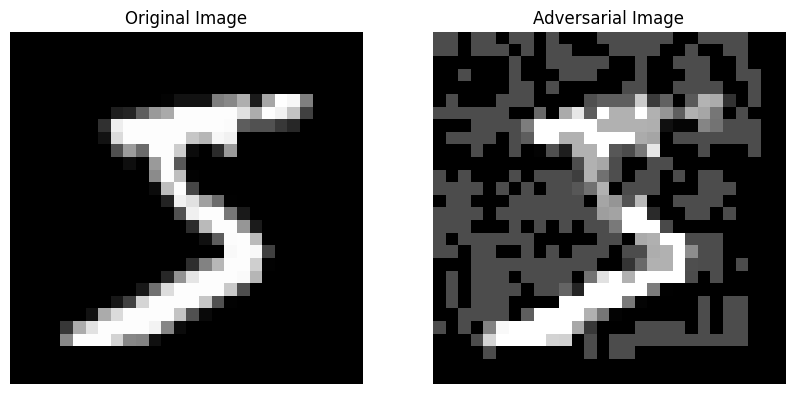

Original Prediction: [5]
Adversarial Prediction: [3]


In [63]:

# Main function to run the code
def main():
    # Load and prepare data
    (x_train, y_train), (x_test, y_test) = load_mnist_data()

    # Create and train the model
    model = create_model()
    model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

    # Step 1: Generate adversarial example
    original_image, adversarial_image, original_pred, adversarial_pred = generate_adversarial_example(model, epsilon=0.3)

    # Step 2: Visualize the images
    visualize_examples(original_image, adversarial_image)

    # Step 3: Print the predictions
    print(f"Original Prediction: {original_pred}")
    print(f"Adversarial Prediction: {adversarial_pred}")

if __name__ == "__main__":
    main()


In [64]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets

# Generate adversarial example using FGSM
def generate_adversarial_example(model, image, label, epsilon=0.3):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # One-hot encode the label
    true_label = tf.one_hot(label, depth=10)
    true_label = tf.expand_dims(true_label, axis=0)  # Add batch dimension

    with tf.GradientTape() as tape:
        tape.watch(image)  # Watch the image tensor for gradients
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(true_label, prediction)

    gradient = tape.gradient(loss, image)
    adversarial_image = image + epsilon * tf.sign(gradient)  # FGSM
    adversarial_image = tf.clip_by_value(adversarial_image, 0.0, 1.0)  # Ensure valid pixel values

    return adversarial_image[0]

# Batch generate adversarial examples
def generate_adversarial_examples_for_batch(model, x_batch, y_batch, epsilon=0.3):
    adversarial_images = []
    for image, label in zip(x_batch, y_batch):
        adversarial_image = generate_adversarial_example(model, image, label, epsilon)
        adversarial_images.append(adversarial_image)
    return np.array(adversarial_images)

# Evaluate model performance on clean data
def evaluate_model(model, x_test, y_test):
    # One-hot encode y_test
    y_test_one_hot = tf.one_hot(y_test, depth=10)
    test_loss, test_acc = model.evaluate(x_test, y_test_one_hot, verbose=2)
    print(f"Test accuracy on clean data: {test_acc}")

# Evaluate model performance on adversarial data
def evaluate_on_adversarial_data(model, x_test, y_test, epsilon=0.3, batch_size=64):
    correct_predictions = 0
    total_predictions = len(x_test)

    # Process data in batches
    for i in range(0, total_predictions, batch_size):
        batch_images = x_test[i:i+batch_size]
        batch_labels = y_test[i:i+batch_size]

        # Generate adversarial examples for the batch
        adversarial_images = generate_adversarial_examples_for_batch(model, batch_images, batch_labels, epsilon)

        # Get model predictions on adversarial images
        adversarial_preds = np.argmax(model(adversarial_images), axis=1)

        # Count correct predictions
        correct_predictions += np.sum(adversarial_preds == batch_labels)

    adversarial_accuracy = correct_predictions / total_predictions
    print(f"Adversarial accuracy: {adversarial_accuracy}")

# Main function for evaluation
def main():
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
    x_test = np.expand_dims(x_test, axis=-1) / 255.0  # Normalize and expand dims for CNN

    # Load the pre-trained model
    model = tf.keras.models.load_model("mnist_model.h5")

    # Evaluate on clean test data
    evaluate_model(model, x_test, y_test)

    # Evaluate on adversarial test data
    evaluate_on_adversarial_data(model, x_test, y_test, epsilon=0.1, batch_size=64)

if __name__ == "__main__":
    main()


313/313 - 1s - 2ms/step - accuracy: 0.9907 - loss: 0.0282
Test accuracy on clean data: 0.9907000064849854
Adversarial accuracy: 0.8865


313/313 - 1s - 2ms/step - accuracy: 0.9907 - loss: 0.0282
Test accuracy on clean data: 0.9907000064849854
Adversarial accuracy: 0.0000


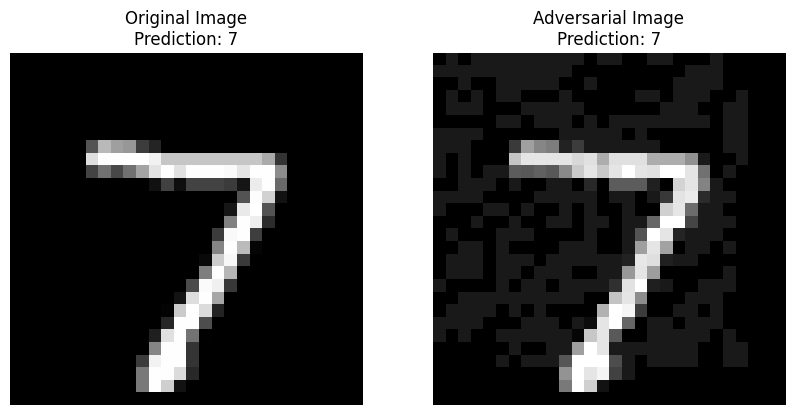

In [65]:
import matplotlib.pyplot as plt

def visualize_results(original_image, adversarial_image, original_pred, adversarial_pred):
    # Plot the original image and adversarial image side by side
    plt.figure(figsize=(10, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')  # Squeeze to remove extra dimensions
    plt.title(f"Original Image\nPrediction: {original_pred}")
    plt.axis('off')

    # Adversarial image
    plt.subplot(1, 2, 2)
    plt.imshow(adversarial_image.squeeze(), cmap='gray')
    plt.title(f"Adversarial Image\nPrediction: {adversarial_pred}")
    plt.axis('off')
    
    plt.show()

def plot_accuracy(clean_accuracy, adversarial_accuracy):
    # Plot the accuracy for clean and adversarial data
    labels = ['Clean', 'Adversarial']
    accuracies = [clean_accuracy, adversarial_accuracy]
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels, accuracies, color=['blue', 'red'])
    plt.title('Accuracy on Clean vs Adversarial Data')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

def generate_adversarial_example(model, image, label, epsilon=0.1):
    # Convert image to float32 and ensure it's a tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Add batch dimension (1, 28, 28, 1) to match model's expected input shape
    image = tf.expand_dims(image, axis=0)

    # Get the true label's one-hot encoded format
    true_label = tf.one_hot(label, depth=10)

    # Add batch dimension to the true label to match the prediction shape
    true_label = tf.expand_dims(true_label, axis=0)

    # Record the gradient of the loss with respect to the image
    with tf.GradientTape() as tape:
        tape.watch(image)  # Watch the image tensor for gradients
        prediction = model(image)  # Get model predictions
        loss = tf.keras.losses.categorical_crossentropy(true_label, prediction)  # Compute loss

    # Compute the gradient of the loss with respect to the image
    gradient = tape.gradient(loss, image)

    # Generate the adversarial image by adding the sign of the gradient to the original image
    adversarial_image = image + epsilon * tf.sign(gradient)

    # Clip the adversarial image to ensure pixel values remain in a valid range
    adversarial_image = tf.clip_by_value(adversarial_image, 0.0, 1.0)

    # Get predictions for both original and adversarial images
    original_pred = np.argmax(model(image), axis=1)
    adversarial_pred = np.argmax(model(adversarial_image), axis=1)

    # Return only the images and predictions (we will modify the return statement accordingly)
    return image[0].numpy(), adversarial_image[0].numpy(), original_pred[0], adversarial_pred[0]


# Assuming you have the adversarial image generation and evaluation as before
def main():
    # Load the model and data
    model = tf.keras.models.load_model("mnist_model.h5")
    (x_train, y_train), (x_test, y_test) = load_mnist_data()

    # One-hot encode the labels for evaluation
    y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)  # One-hot encoding for the labels

    # Evaluate on clean test data
    clean_loss, clean_acc = model.evaluate(x_test, y_test_one_hot, verbose=2)  # Use one-hot encoded labels
    print(f"Test accuracy on clean data: {clean_acc}")

    # Generate adversarial example for a sample (using the first image from the test set)
    original_image = x_test[0]  # Use the first image from the test set
    label = y_test[0]  # Use the corresponding label for the first image
    original_image, adversarial_image, original_pred, adversarial_pred = generate_adversarial_example(model, image=original_image, label=label, epsilon=0.1)

    # Evaluate on adversarial data
    adversarial_accuracy = np.mean(original_pred != adversarial_pred)  # This gives adversarial accuracy
    
    print(f"Adversarial accuracy: {adversarial_accuracy:.4f}")

    # Plot the results
    visualize_results(original_image, adversarial_image, original_pred, adversarial_pred)
    
if __name__ == "__main__":
    main()
